# Introduction

In this article, I'll try to show you a few examples of Meta Prophet usage and some tweaks to improve the quality of the model, especially if it obtains a low score with standard parameters.

In general, Prophet is a free library with R and Python APIs. The tool is fairly easy to use for those familiar with the Pandas and NumPy libraries and the complete basics of machine learning.

In summary, this paper requires some knowledge in machine learning, however, thanks to Prophet's intuitive interface and advanced features, it can be used by individuals who do not possess specialized knowledge in this field. The length of the article should not be a concern, as a significant portion is dedicated to clear and informative graphs that allow for quick and easy understanding of the analyzed data. With this tool, forecasting trends and behaviors based on data becomes simpler and more intuitive.

# 1. Daily number of posts on medium.com website

[This dataset](https://www.kaggle.com/datasets/kashnitsky/mlcourse?select=medium_posts.csv) contains the dates of posts published on medium.com. We can sum the daily number of posts and try to forecast future values.

## Load the data

In [1]:
from common import *

df = pd.read_csv('medium_posts.csv')
df['published_date'] = pd.to_datetime(df['published']).dt.date
df = df.drop(columns='published')

df_by_day = df['published_date'].value_counts().sort_index() # sum articles for each year
df_by_day = df_by_day.to_frame().reset_index()
df_by_day.rename(columns={"published_date": "y", "index": "ds"}, inplace=True) # rename columns using Prophet's convention
print("First five rows:")
df_by_day.head()

First five rows:


,ds,y
0,1970-01-01,2
1,1970-01-18,3
2,2003-09-14,1
3,2004-04-04,1
4,2004-04-16,1


Two rows are from 1970 - it's probably an error. Let's remove them and plot the data:

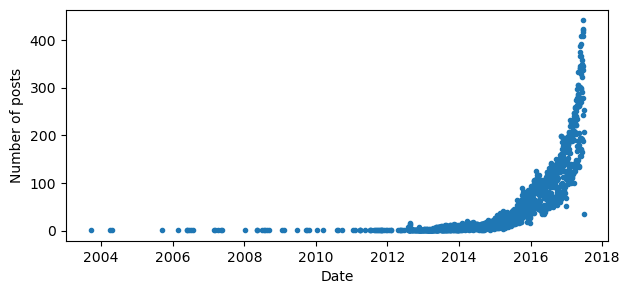

In [2]:
df_by_day = df_by_day.iloc[2:]
plt.figure(figsize=(7,3))
plt.plot(df_by_day['ds'], df_by_day['y'], '.')
plt.xlabel("Date")
plt.ylabel("Number of posts");

Until 2013 there are a lot of dates without number of posts. In these years Medium was probably very small website and using that thata can lead to unreliable predictions. I'll cut all rows to 01-01-2013.

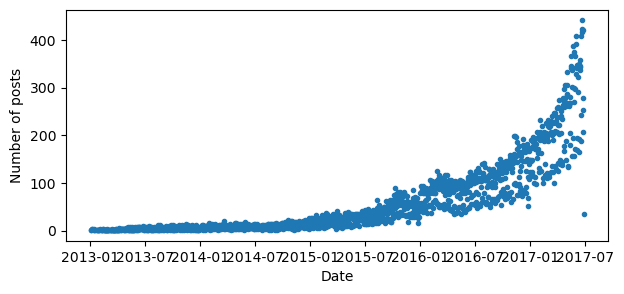

In [4]:
cut_date = datetime.date(2013, 1, 1)
df_by_day = df_by_day[df_by_day.ds > cut_date]
plt.figure(figsize=(7,3))
plt.plot(df_by_day['ds'], df_by_day['y'], '.')
plt.xlabel("Date")
plt.ylabel("Number of posts");

## Prediction for standard parameters, forecast components:

The next paragraph of the article describes a code snippet that initializes a Prophet model, fits data from the previous cell, and generates a one-year forecast. It's almost the simplest case. There is one tweak: the growth type is specified as 'logistic', which often works better for data with non-linear (for example - exponential) growth. With this parameter, we need to set the maximum value. Optionally, we can specify a minimum value. By default, floor is specified as 0, so in this case I don't need to write it myself.

Fitting time: 0.234s
Predicting time: 0.632s


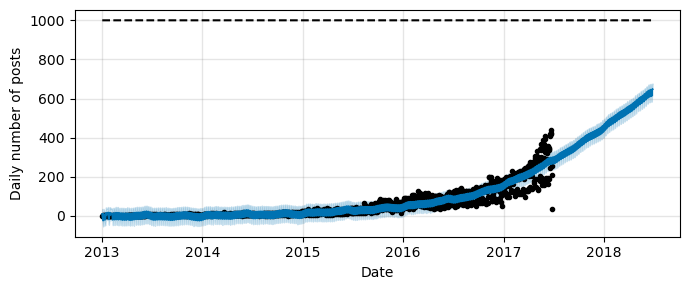

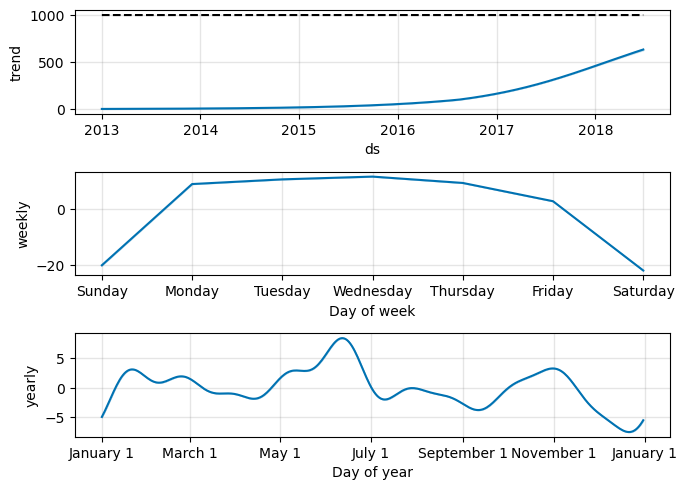

In [11]:
import logging
logging.getLogger('cmdstanpy').setLevel(logging.ERROR)

import time

m = Prophet(growth='logistic')
df_by_day['cap'] = 1000
start = time.time()
m.fit(df_by_day)
end = time.time()
print("Fitting time: %.3fs" % (end-start))
future = m.make_future_dataframe(periods=365)
future['cap'] = 1000
start = time.time()
forecast = m.predict(future)
end = time.time()
print("Predicting time: %.3fs" % (end-start))
fig1 = m.plot(forecast, figsize=(7, 3), xlabel='Date', ylabel='Daily number of posts')
fig2 = m.plot_components(forecast, figsize=(7, 5))

The last three plots show trends and seasonalities.

Trend refers to the long-term pattern or direction of the data, which can be increasing, decreasing, or stable over time. It can also have [changepoints](https://facebook.github.io/prophet/docs/trend_changepoints.html). In Prophet, the trend is modeled with a regression function.

Seasonality, on the other hand, refers to the repetitive patterns or cycles that occur over a period of time. For example, sales of ice cream may show a peak in the summer months and a trough in the winter months, while website traffic may exhibit higher levels on weekdays than on weekends. In Prophet, seasonality is modeled with Fourier series, a mathematical technique that decomposes a periodic signal into a sum of sine and cosine waves with different frequencies, amplitudes, and phases.

In these plots, we see a trend, probably with exponential growth, and two types of seasonalities. Users publish fewer posts on Saturday and Sunday, in addition to the fact that activity varies throughout the year.

## Cross validation, metrics

Cross validation is an important step in evaluating the performance of Prophet models. In cross validation, the historical data is split into multiple segments, and the model is trained on one segment and tested on the others. This process is repeated multiple times to obtain an average measure of performance. Cross validation helps to assess the model's ability to generalize to new data and can provide insight into how the model may perform in the future.

In this example, the starting segment will consist of first 730 days ("initial") of the dataset, which will be used for training the model. The next 365 days ("horizon") will be used as a test set to evaluate the model's performance. After that, 182 days ("period") will be added to both the start and end of these ranges, creating the next train and test segments. This process will be repeated until the dataset is too small for the next iteration.

  0%|          | 0/3 [00:00<?, ?it/s]

Cross-validation calculation time: 1.330s
Mean MAE: 25.719122798589403
Mean MAPE: 29.287699249711096 %


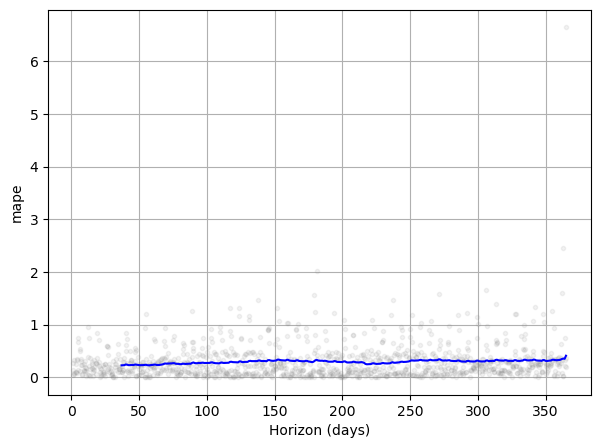

In [14]:
import logging
logging.getLogger('cmdstanpy').setLevel(logging.CRITICAL)
start = time.time()
df_cv = cross_validation(m, initial='730 days', period='182 days', horizon = '365 days')
end = time.time()
print("Cross-validation calculation time: %.3fs" % (end-start))
df_p = performance_metrics(df_cv)
print("Mean MAE:", str(df_p['mae'].mean()))
print("Mean MAPE:", str(df_p['mape'].mean() * 100), '%')
fig = plot_cross_validation_metric(df_cv, metric='mape', figsize=(7, 5))

What are these values and the plot in the cell above? The first two numbers show how well the model performed on the test data during cross-validation.

MAE (Mean Absolute Error) measures the average absolute difference between predicted and actual values. It is calculated by taking the average of the absolute differences between predicted and actual values for each data point.

MAPE (Mean Absolute Percentage Error) measures the average absolute percentage difference between predicted and actual values. It is calculated by taking the average of the absolute percentage differences between the predicted and actual values for each data point. MAPE provides information about the magnitude of the errors relative to the actual values. MAPE is useful when the scale of the data varies significantly, as it takes into account the relative size of the errors.

The plot above shows how the MAPE varies with the prediction horizon.

Now let's look at a specific forecast for all cross-validation splits and later for a single year.

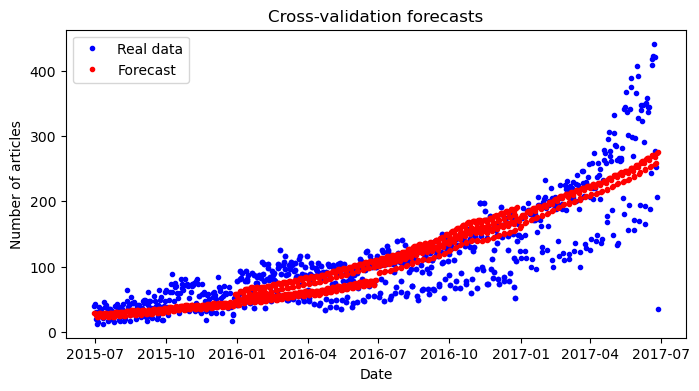

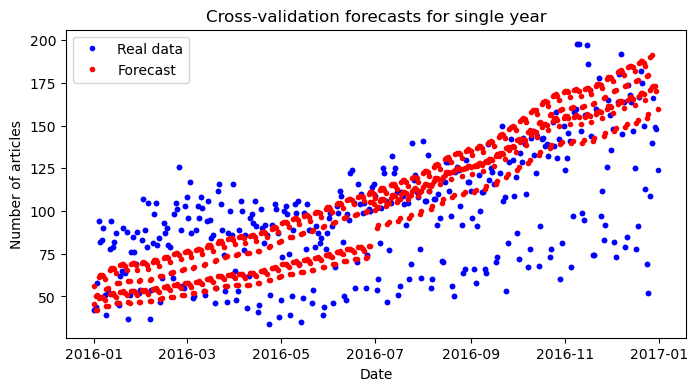

In [14]:
plot_cv_forecast_df(df_cv, ylabel="Number of articles")
plot_cv_forecast_df(df_cv, ylabel="Number of articles", lower_date = np.datetime64('2016-01-01'), upper_date = np.datetime64('2017-01-01'), title="Cross-validation forecasts for single year")

As you can see, the model can detect the general trend, but it has problems in determining the values more accurately. If these fluctuations are not completely random, we should be able to provide better results.

## Hyperparameters tuning

Hyperparameter tuning refers to the process of selecting the optimal values of the hyperparameters of a machine learning model, which are the parameters that control the behavior and performance of the model but are not learned from the data. Here I'll tune:
- changepoint_prior_scale - "flexibility of the trend, and in particular how much the trend changes at the trend changepoints"
- changepoint_range - "proportion of the history in which the trend is allowed to change"
- holidays_prior_scale - "controls flexibility to fit holiday effects"
- seasonality_mode - additive or multiplicative
- seasonality_prior_scale - "controls the flexibility of the seasonality"
<br/><sub>Descriptions from [documentation](https://facebook.github.io/prophet/docs/diagnostics.html#hyperparameter-tuning)</sub>

Tuning the hyperparameters can improve the accuracy and robustness of the model, as well as prevent overfitting or underfitting. This is often done by exploring a range of hyperparameter values and evaluating their performance on a validation set or through cross-validation. The cell below contains "Bayesian optimization" - we need to specify ranges for each parameter, and the tool will search for the best values within this range.

In [8]:
import warnings
warnings.filterwarnings("ignore")

tune_optuna_logistic(df_by_day, 1000, save_study_name="medium-study", metric='mape')

[I 2023-03-12 12:08:40,182] A new study created in RDB with name: medium-study-logistic-mape-shorter-cut


Best trial:
   mape :  0.16693401279454115
  Params: 
    changepoint_prior_scale: 0.3758001747787103
    changepoint_range: 0.9318725689779309
    holidays_prior_scale: 0.017984952317648
    seasonality_mode: multiplicative
    seasonality_prior_scale: 0.029518181474767858


Fitting time: 0.357s
Predicting time: 0.625s


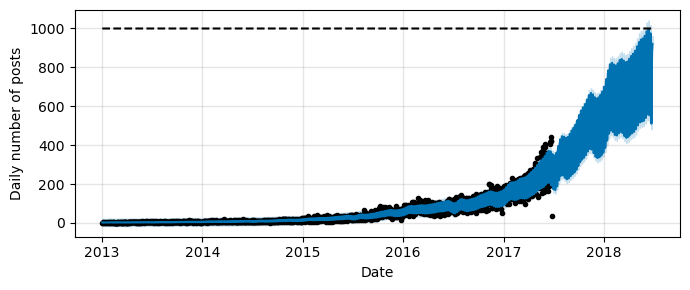

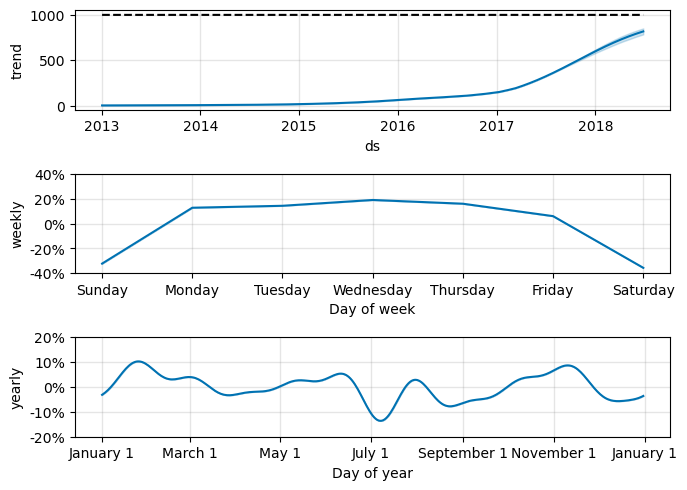

In [15]:
m = Prophet(changepoint_prior_scale=0.3758001747787103, changepoint_range=0.9318725689779309,
           holidays_prior_scale=0.017984952317648, seasonality_mode='multiplicative',
           seasonality_prior_scale=0.029518181474767858, growth='logistic')
start = time.time()
m.fit(df_by_day)
end = time.time()
print("Fitting time: %.3fs" % (end-start))
future = m.make_future_dataframe(periods=365)
future['cap'] = 1000
start = time.time()
forecast = m.predict(future)
end = time.time()
print("Predicting time: %.3fs" % (end-start))
fig1 = m.plot(forecast, figsize=(7, 3), xlabel='Date', ylabel='Daily number of posts')
fig2 = m.plot_components(forecast, figsize=(7, 5))

What are the main differences? The trend looks very similar, but this model takes seasonality much more strongly into account. This results in higher prediction fluctuations and higher accuracy. The best way to see this is to plot a single year:

  0%|          | 0/3 [00:00<?, ?it/s]

Cross-validation calculation time: 1.412s
Mean MAE: 18.458596128416353


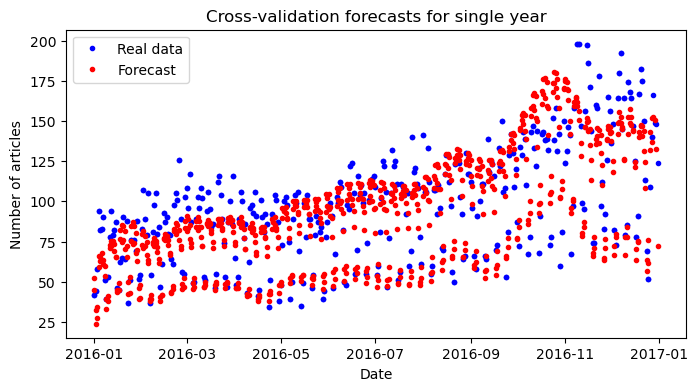

In [16]:
logging.getLogger('cmdstanpy').setLevel(logging.CRITICAL)
start = time.time()
df_cv = cross_validation(m, initial='730 days', period='182 days', horizon = '365 days')
end = time.time()
print("Cross-validation calculation time: %.3fs" % (end-start))
df_p = performance_metrics(df_cv)
print("Mean MAE:", str(df_p['mae'].mean()))
plot_cv_forecast_df(df_cv, ylabel="Number of articles", lower_date = np.datetime64('2016-01-01'), upper_date = np.datetime64('2017-01-01'), title="Cross-validation forecasts for single year")

Finally, tuning resulted in an increase in MAPE from ~29.28% to ~16.69%.

# 2. Forecasting the hourly number of ads

In the next section of the article, we will introduce a [new dataset](https://www.kaggle.com/datasets/kashnitsky/mlcourse?select=ads.csv) that contains hourly counts of ad views over nine days. This dataset provides a good example of how to forecast time series at an hourly frequency, which requires dealing with higher levels of volatility and noise than daily or weekly frequencies. We will use Prophet to model and forecast the hourly time series, and demonstrate how to apply the concepts and techniques discussed earlier in the article to a higher of time granularity.

## Load the data, first simple model

Fitting time: 0.024s
Predicting time: 0.054s


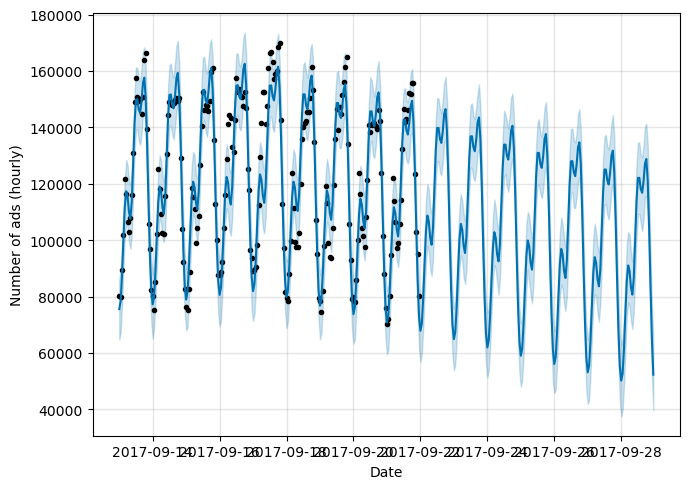

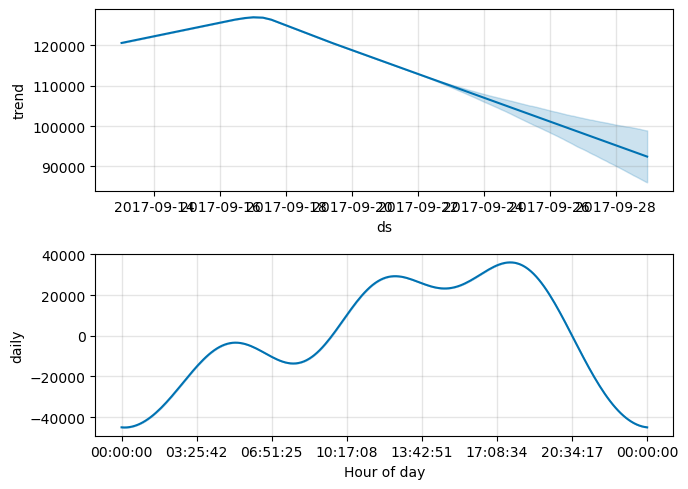

In [17]:
df = pd.read_csv('ads.csv')
df.rename(columns={"Time":"ds", "Ads":"y"}, inplace=True)

m = Prophet()

start = time.time()
m.fit(df)
end = time.time()
print("Fitting time: %.3fs" % (end-start))

future = m.make_future_dataframe(periods=24*7, freq='H')
start = time.time()
forecast = m.predict(future)
end = time.time()
print("Predicting time: %.3fs" % (end-start))

fig1 = m.plot(forecast, xlabel="Date", ylabel="Number of ads (hourly)", figsize=(7, 5))
fig2 = m.plot_components(forecast, figsize=(7, 5))

It's difficult to determine whether the trend has been correctly described, but it looks like daily seasonality makes sense. Daily fluctuations seem pretty good.

Let's calculate MAPE score and plot cross-validation forecasts:

Cross-validation calculation time: 0.152s
Mean MAPE:  0.06944672897219573


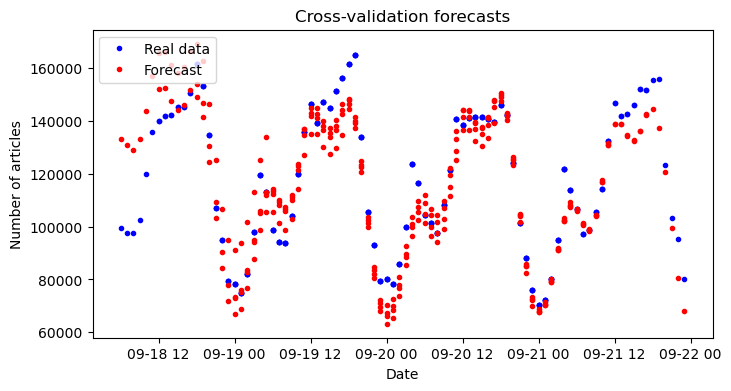

In [18]:
start = time.time()
df_cv = cross_validation(m, initial='5 days', period='6 hours', horizon = '24 hours', parallel="processes")
end = time.time()
print("Cross-validation calculation time: %.3fs" % (end-start))
df_p = performance_metrics(df_cv)
print("Mean MAPE: ", str(df_p['mape'].mean()))
plot_cv_forecast_df(df_cv, ylabel="Number of articles")

Using Prophet standard parameters we were able to achieve a mean absolute percentage error (MAPE) below 7%, which is a relatively good result. This demonstrates the effectiveness of Prophet in some cases.

## Tune model and compare results

In [12]:
tune_optuna(df, save_study_name='ads', metric="mape", initial='5 days', period='6 hours', horizon='24 hours')

/home/jsowa/work/prophet/common.py:83: ExperimentalWarning: enqueue_trial is experimental (supported from v1.2.0). The interface can change in the future.
  study.enqueue_trial({
/home/jsowa/anaconda3/envs/prophetenv/lib/python3.11/site-packages/optuna/study/study.py:857: ExperimentalWarning: create_trial is experimental (supported from v2.0.0). The interface can change in the future.
  create_trial(state=TrialState.WAITING, system_attrs={"fixed_params": params})
/home/jsowa/anaconda3/envs/prophetenv/lib/python3.11/site-packages/optuna/study/study.py:856: ExperimentalWarning: add_trial is experimental (supported from v2.0.0). The interface can change in the future.
  self.add_trial(


Best trial:
   mape :  0.06087658873860407
  Params: 
    changepoint_prior_scale: 0.035033218143421044
    changepoint_range: 0.8548855487747484
    holidays_prior_scale: 4.158901360548356
    seasonality_mode: additive
    seasonality_prior_scale: 0.029310502345129764


Predictions are more accurate by about 0.9 percentage points. To be honest, it's not enough to see it at a glance on the plot, so I won't print it.

# 3. Bike sharing demand dataset

[This dataset](https://www.kaggle.com/c/bike-sharing-demand) contains information about how many people rented a bike at a given hour. It's a nice example to show how additional features associated with the target can be used in Prophet for forecasting. I'll also use one preprocessing tweak which is not an internal tool of the Prophet library.


## Load the data, train first simple model

In [19]:
df = pd.read_csv('bike_demand.csv')
df.rename(columns={"datetime":"ds", "count":"y"}, inplace=True)
df.head()

,ds,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,y
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


Let's train the simplest model - with standard parameters.

Fitting time: 0.865s
Predicting time: 2.205s


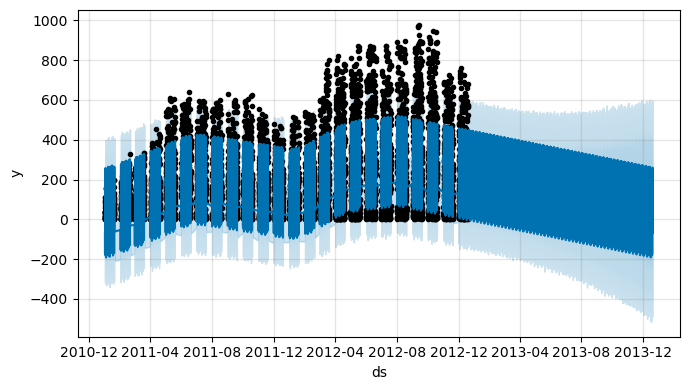

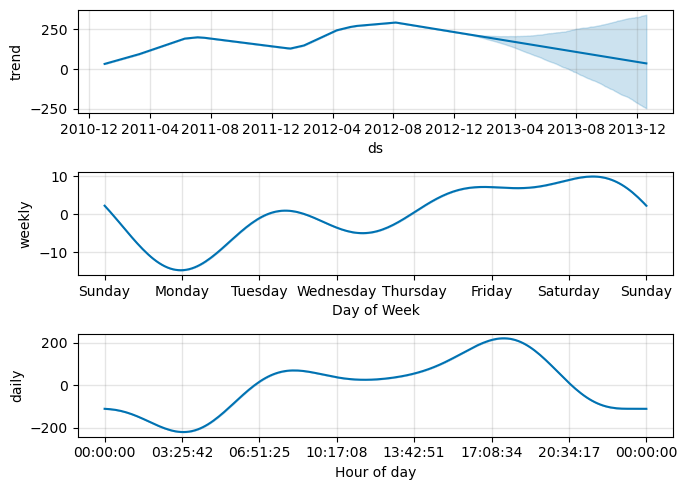

In [24]:
m = Prophet()
start = time.time()
m.fit(df)
end = time.time()
print("Fitting time: %.3fs" % (end-start))

future = m.make_future_dataframe(periods=24*365, freq='H')
start = time.time()
forecast = m.predict(future)
end = time.time()
print("Predicting time: %.3fs" % (end-start))
fig1 = m.plot(forecast, figsize=(7, 4))
fig2 = m.plot_components(forecast, figsize=(7, 5))

What's wrong with this forecast? By default, Prophet looks for yearly seasonality only if there are two full years of data. This kind of information is very important in this model. People, for example, ride their bikes less frequently in the winter than they do in the summer.

Before the next model, let's check the cross-validation of a single week's forecast - it's nice to have it for later comparison.

Cross-validation calculation time: 15.164s
Mean cross-validation MAE:  106.00845004933414


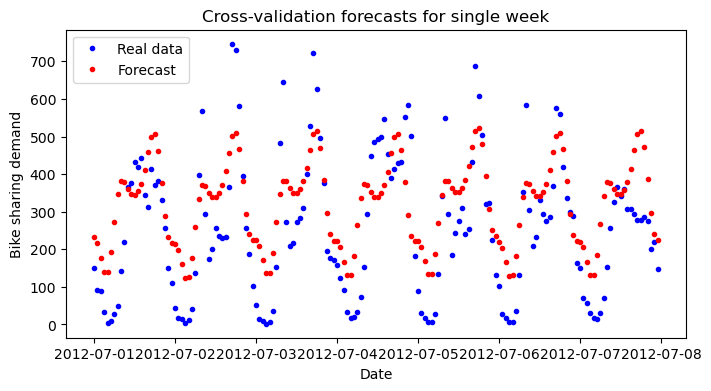

In [22]:
logging.getLogger('cmdstanpy').setLevel(logging.ERROR)
start = time.time()
df_cv = cross_validation(m, initial='365 days', period='7 days', horizon = '7 days', parallel="processes")
end = time.time()
print("Cross-validation calculation time: %.3fs" % (end-start))

df_p = performance_metrics(df_cv)
print("Mean cross-validation MAE: ", str(df_p['mae'].mean()))

lower_date = np.datetime64('2012-07-01')
upper_date = np.datetime64('2012-07-08')
plot_cv_forecast_df(df_cv, ylabel="Bike sharing demand", lower_date = lower_date, upper_date = upper_date, title="Cross-validation forecasts for single week")

## Add yearly seasonality

For more reliable forecast I'll try to add yearly seasonality manually:

Fitting time: 0.855s
Predicting time: 2.234s


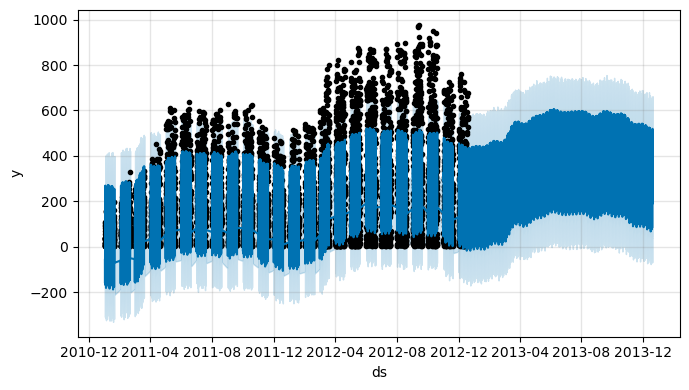

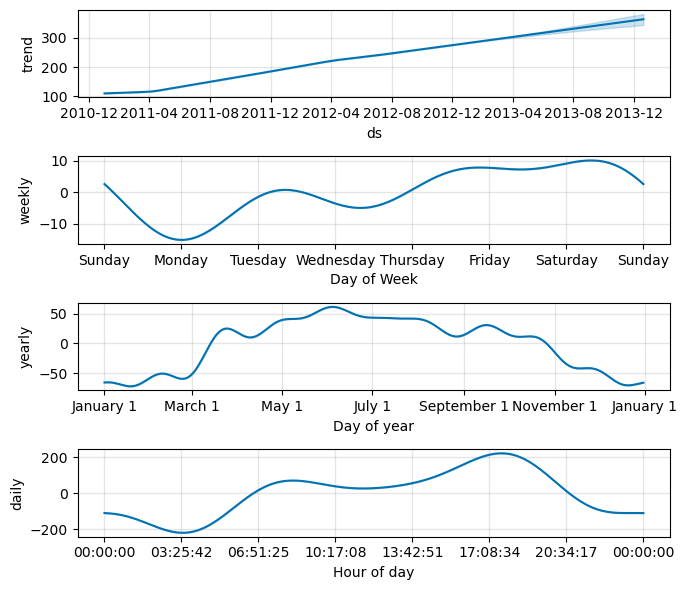

In [27]:
m = Prophet()
m.add_seasonality(name='yearly', period=365, fourier_order=10)
start = time.time()
m.fit(df)
end = time.time()
print("Fitting time: %.3fs" % (end-start))
future = m.make_future_dataframe(periods=24*365, freq='H')
start = time.time()
forecast = m.predict(future)
end = time.time()
print("Predicting time: %.3fs" % (end-start))
fig1 = m.plot(forecast, figsize=(7, 4))
fig2 = m.plot_components(forecast, figsize=(7, 6))

Now the trend looks completely different, and the forecast for next year looks more reliable.

In [28]:
logging.getLogger('cmdstanpy').setLevel(logging.ERROR)
start = time.time()
df_cv = cross_validation(m, initial='365 days', period='7 days', horizon = '7 days', parallel="processes")
end = time.time()
print("Cross-validation calculation time: %.3fs" % (end-start))
df_p = performance_metrics(df_cv)
print("Mean MAE: ", str(df_p['mae'].mean()))

Cross-validation calculation time: 12.941s
Mean MAE:  102.04763012417447


More likely future forecasts are the most important benefit, but at the same time, the cross-validation score was able to improve by several points.

## Add the minimum prediction value by using the logarithmic and exponential functions

What's the next issue? Some of the forecast predictions are... below zero! We know that it's completely irrational - it is not possible for a negative number of bicycles to be rented.

I'll show you one way to fix it. We can first logarithmize the values before fitting them and then apply an exponential function to them. The value of the exponential function is always positive, so the final targets will also be positive.

In [29]:
df = pd.read_csv('bike_demand.csv')
df.rename(columns={"datetime":"ds", "count":"real_y"}, inplace=True)
df["y"] = np.log(df["real_y"])

m = Prophet()
m.add_seasonality(name='yearly', period=365, fourier_order=10)
start = time.time()
m.fit(df)
end = time.time()
print("Fitting time: %.3fs" % (end-start))
future = m.make_future_dataframe(periods=24*365, freq='H')
start = time.time()
forecast = m.predict(future)
end = time.time()
print("Predicting time: %.3fs" % (end-start))

logging.getLogger('cmdstanpy').setLevel(logging.ERROR)
start = time.time()
df_cv = cross_validation(m, initial='365 days', period='7 days', horizon = '7 days', parallel="processes")
end = time.time()
print("Cross validation calculation time: %.3fs" % (end-start))
mae = np.abs(np.exp(df_cv["yhat"]) - np.exp(df_cv["y"])).mean()

print("Mean MAE:", str(mae))

Fitting time: 0.626s
Predicting time: 2.238s
Cross validation calculation time: 12.967s
Mean MAE: 87.99573783891074


This tweak noticeably improved the score - by almost 20 points.

## Add regressors

In Prophet, additional regressors are external variables that can be used to help improve the accuracy of the forecast. These variables are not time-dependent and are assumed to be known for future time periods. Examples of additional regressors in a business context could include holidays, events, weather data, or economic indicators. Including such variables in the model can capture their impact on the target variable and help adjust the forecast accordingly. The use of additional regressors can be particularly *effective in improving the forecast* accuracy of time series that are ***influenced by external factors beyond their intrinsic trends and seasonality***.

In real-life scenarios, we may not have access to certain external variables, such as future weather data, that could potentially influence the target variable we are trying to forecast. This Kaggle dataset contains these features in both the train and test csv files, but you always have to analyze if it is possible to use specific information.

In [30]:
m = Prophet()
m.add_seasonality(name='yearly', period=365, fourier_order=10)
m.add_regressor('weather')
m.add_regressor('atemp')
m.add_regressor('humidity')
m.add_regressor('workingday')
m.add_regressor('temp')
start = time.time()
m.fit(df)
end = time.time()
print("Fitting time: %.3fs" % (end-start))
start = time.time()
df_cv = cross_validation(m, initial='365 days', period='7 days', horizon = '7 days', parallel="processes")
end = time.time()
print("Cross-validation calculation time: %.3fs" % (end-start))
mae = np.abs(np.exp(df_cv["yhat"]) - np.exp(df_cv["y"])).mean()
print("Mean MAE : ", str(mae))

Fitting time: 0.758s
Cross-validation calculation time: 13.846s
Mean MAE :  83.49451161706348


The difference may not be staggering, but we gained another few points with only a slightly slower model.

## Tune hyperparameters

In [20]:
tune_optuna_mae_exp(df, 1000, save_study_name="bike_demand_hourly_log", trials_number=100,
                    regressors=['weather', 'atemp', 'humidity', 'workingday', 'temp'],
                   manual_yearly_seasonality=True)

Best trial:
  MAE:  82.7451599850776
  Params: 
    changepoint_prior_scale: 0.9895422205291365
    changepoint_range: 0.657223678519697
    holidays_prior_scale: 32.14468171586942
    seasonality_mode: additive
    seasonality_prior_scale: 0.02168372346833077


This time the tuning raised the score only slightly, which shows that the default parameters are sometimes already quite good. Finally, let's look at the cross-validation forecast for a single week.

Fitting time: 2.056s
Cross-validation calculation time: 49.753s


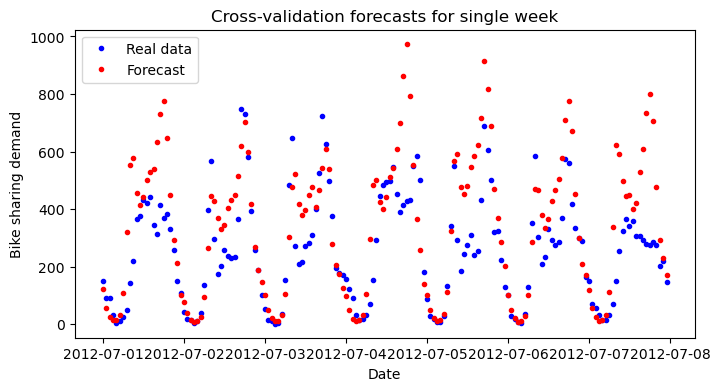

In [31]:
m = Prophet(changepoint_prior_scale=0.9895422205291365, seasonality_prior_scale=0.02168372346833077,
                holidays_prior_scale=32.14468171586942, seasonality_mode="additive",
                changepoint_range=0.657223678519697)
m.add_seasonality(name='yearly', period=365, fourier_order=10)
m.add_regressor('weather')
m.add_regressor('atemp')
m.add_regressor('humidity')
m.add_regressor('workingday')
m.add_regressor('temp')

m.add_seasonality(name='yearly', period=365, fourier_order=10)
start = time.time()
m.fit(df)  # Fit model with given params
end = time.time()
print("Fitting time: %.3fs" % (end-start))
logging.getLogger('cmdstanpy').setLevel(logging.ERROR)
start = time.time()
df_cv = cross_validation(m, initial='365 days', period='7 days', horizon = '7 days', parallel="processes")
end = time.time()
print("Cross-validation calculation time: %.3fs" % (end-start))
exp_df_cv = df_cv.copy()
exp_df_cv["y"] = np.exp(exp_df_cv["y"])
exp_df_cv["yhat"] = np.exp(exp_df_cv["yhat"])

lower_date = np.datetime64('2012-07-01')
upper_date = np.datetime64('2012-07-08')
plot_cv_forecast_df(exp_df_cv, ylabel="Bike sharing demand", lower_date = lower_date, upper_date = upper_date, title="Cross-validation forecasts for single week")

As in the previous examples, we see that after several corrections, the model's predictions have larger fluctuations, leading to better results.

# Summary

To sum up, the article covered the basics of time series forecasting using the Prophet library. The library can often work well with default parameters, but ***tuning the hyperparameters*** can improve the forecast accuracy. The Bayesian Optimization method was found to be effective in our examples. The ***logistic growth model*** should be used for nonlinear growth, and ***additional regressors*** can improve forecast accuracy. It is also worth considering ***data transformations, such as taking the logarithm***, to improve the model's performance. Finally, the importance of proper handling of external variables and avoiding information leakage was emphasized to build accurate and robust time series forecasts.